# Diffuse Emission

In [1]:
#source /export/ciao/bin/ciao.bash -o
PFILES="./param;$ASCDS_INSTALL/param:$ASCDS_INSTALL/contrib/param"
mkdir -p ./param
ASCDS_WORK_PATH=./

## Download Data and repro

In [2]:
/bin/rm -rf 315 
download_chandra_obsid 315 evt1,pbk,bias,flt,fov,msk,mtl,bpix,asol,dtf,stat 


  Type     Format      Size  0........H.........1  Download Time Average Rate
  ---------------------------------------------------------------------------
  evt1     fits      213 Mb  ####################           14 s  15621.7 kb/s
  asol     fits       19 Mb  ####################            1 s  13466.3 kb/s
  mtl      fits        3 Mb  ####################          < 1 s  6940.8 kb/s
  stat     fits        2 Mb  ####################          < 1 s  20097.2 kb/s
  bias     fits      500 Kb  ####################          < 1 s  22581.7 kb/s
  bias     fits      448 Kb  ####################          < 1 s  16520.4 kb/s
  bias     fits      441 Kb  ####################          < 1 s  23026.1 kb/s
  bias     fits      441 Kb  ####################          < 1 s  19383.5 kb/s
  bias     fits      440 Kb  ####################          < 1 s  16661.9 kb/s
  bpix     fits       10 Kb  ####################          < 1 s  804.9 kb/s
  flt      fits        7 Kb  ####################       

In [3]:
/bin/rm -rf repro 
chandra_repro 315 ./repro


Running chandra_repro
version: 14 September 2021


Processing input directory '/proj/sds/Staff/kjg/Threads/diffuse_emission/315'

Applying boresight update to aspect solution file
Resetting afterglow status bits in evt1.fits file...

Running the destreak tool on the evt1.fits file...

Running acis_build_badpix and acis_find_afterglow to create a new bad pixel file...

Running acis_process_events to reprocess the evt1.fits file...
Output from acis_process_events:
# acis_process_events (CIAO 4.14): WARNING: The ra_targ, dec_targ, or roll_nom specified by /proj/sds/Staff/kjg/Threads/diffuse_emission/repro/pcadf00315_repro_obs.par does not match the values in the event file- using the obs.par values.
# acis_process_events (CIAO 4.14): WARNING: problem reading ctifile, cti adjustment will not be applied. Changing apply_cti=yes to apply_cti=no.
Filtering the evt1.fits file by grade and status and time...
Applying the good time intervals from the flt1.fits file...
The new evt2.fits file is: 

In [4]:
# Work around crates bug!
dmcopy "repro/acisf00315_repro_evt2.fits[ccd_id=7]" repro/c7.evt cl+

fluximage "repro/c7.evt" images/ binsize=1 bands=broad clob+ psfecf=0.393

Running fluximage
Version: 23 February 2021

Using CSC ACIS broad science energy band.
Aspect solution repro/pcadf00315_repro_asol1.fits found.
Bad-pixel file repro/acisf00315_repro_bpix1.fits found.
Mask file repro/acisf00315_000N003_msk1.fits found.

The output images will have 1292 by 1289 pixels, pixel size of 0.492 arcsec,
    and cover x=3545.5:4837.5:1,y=3175.5:4464.5:1.

Running tasks in parallel with 4 processors.
Creating aspect histogram for obsid 315
Creating instrument map for obsid 315
Creating exposure map for obsid 315
Thresholding data for obsid 315
Exposure-correcting image for obsid 315
Creating PSF map for obsid 315

The following files were created:

 The clipped counts image is:
     images/broad_thresh.img

 The clipped exposure map is:
     images/broad_thresh.expmap

 The PSF map is:
     images/broad_thresh.psfmap

 The exposure-corrected image is:
     images/broad_flux.img



## Identify and Remove Point Source

### Create an Image of the Region

In [5]:
dmcopy "repro/acisf00315_repro_evt2.fits[energy=300:7000][bin x=4004.5:4404.5:1,y=3625.5:4025.5:1]" \
       original.fits cl+

In [6]:
get_sky_limits images/broad_thresh.img 

Running: get_sky_limits
  version: 07 October 2016
Checking binning of image: images/broad_thresh.img
  Image has 1292 x 1289 pixels
  Pixel size is 1.0 by 1.0
  Lower left (0.5,0.5) corner is x,y= 3545.5, 3175.5
  Upper right (1292.5,1289.5) corner is x,y= 4837.5, 4464.5
  DM filter is:
    x=3545.5:4837.5:#1292,y=3175.5:4464.5:#1289
  mkexpmap xygrid value is:
    3545.5:4837.5:#1292,3175.5:4464.5:#1289


[1] 27624
[1]+  Done                    ds9 images/broad_thresh.img -scale log -zoom 0.5 -smooth -invert -saveimage png ds9_01.png


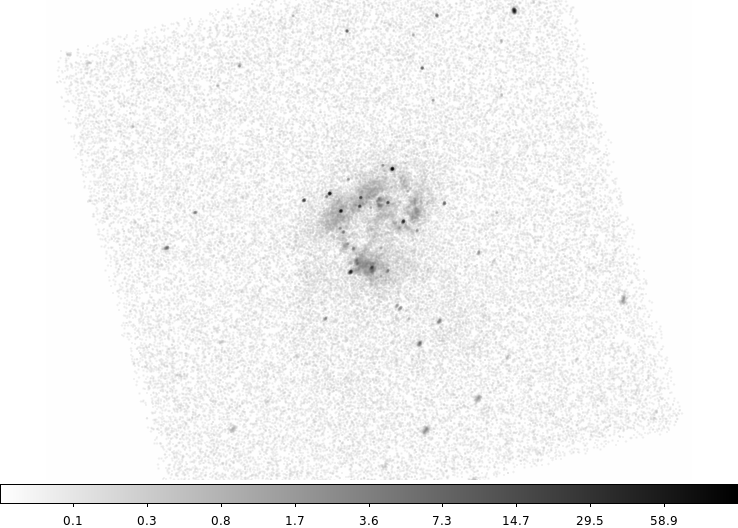

In [7]:
ds9 images/broad_thresh.img -scale log -zoom 0.5 -smooth -invert -saveimage png ds9_01.png &
sleep 10
xpaset -p ds9 quit

display < ds9_01.png

### Source detection with wavdetect

In [8]:
#mkpsfmap images/broad_thresh.img images/broad_thresh.psfmap \
#  energy=1.4967 ecf=0.393 cl+

In [9]:
dmstat images/broad_thresh.psfmap cen-

PSFMAP[arcsec]
    min:	0.24236044288 	      @:	( 4081 4155 )
    max:	3.6420326233 	      @:	( 4826 3446 )
   mean:	1.2049193993 
  sigma:	0.77731644938 
    sum:	1328734.507 
   good:	1102758 
   null:	562630 


In [10]:
###dmimgthresh images/broad_thresh.psfmap psfmap cut=INDEF value=0 clob+

In [11]:
###cat << EOM > chps.cmd
###make_figure("images/broad_thresh.img", "image")
###set_image(["threshold", [0,2], "depth", 50])
###add_contour("psfmap")
###set_contour(["levels", [0.5, 1, 2]])
###set_contour(["color", "red", "thickness", 2])
###zoom(1.5)
###set_xaxis(["tickformat", "%ra"])
###set_yaxis(["tickformat", "%dec"])
###reposition_plot(0.2, 0.15, 0.95, 0.9)
###print_window("chips_1.png","export.clobber=True")
###EOM

###chips -b chps.cmd
###display < chips_1.png

[1] 27711
[1]+  Done                    ds9 images/broad_thresh.img -scale limits 0 2 images/broad_thresh.psfmap -contour -contour smooth 1 -contour levels "0.5 1 2" -contour copy -frame 1 -contour paste wcs red 2 no -contour close -single -pan to 4200 3790 physical -view colorbar no -grid yes -grid grid no -grid type analysis -grid border no -grid title no -grid axes type exterior -grid numerics vertical yes -saveimage png ds9.png


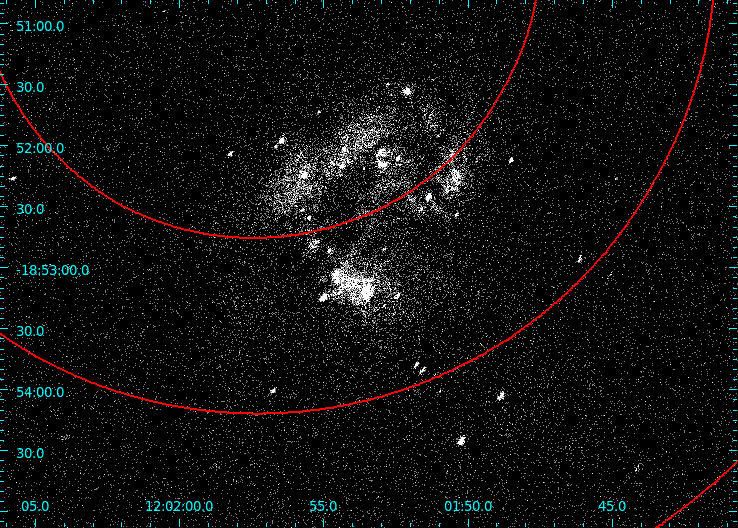

In [12]:
ds9  \
  images/broad_thresh.img -scale limits 0 2 \
  images/broad_thresh.psfmap \
  -contour -contour smooth 1 -contour levels "0.5 1 2" -contour copy \
  -frame 1 -contour paste wcs red 2 no  -contour close -single \
  -pan to 4200 3790 physical -view colorbar no  \
  -grid yes -grid grid no -grid type analysis -grid border no \
  -grid title no -grid axes type exterior -grid numerics vertical yes \
  -saveimage png ds9.png &
sleep 10
xpaset -p ds9 quit


display < ds9.png

In [13]:
pset wavdetect psffile=images/broad_thresh.psfmap
pset wavdetect regfile=sources.reg 
pset wavdetect ellsigma=4
wavdetect images/broad_thresh.img \
  sources.fits sources.scell sources.image sources.nbkg clobber=yes mode=h


Modify, delete non-obvious sources.

__THIS MAY NEED TO BE MODIFIED PER RELEASE IN THE FUTURE__

In [14]:
dmcopy sources.fits"[component=:]" sources_mod.fits cl+


In [15]:
dmmakereg region="region(sources_mod.fits)" out=source_mod.reg clob+ ker=ascii
 

In [16]:
head source_mod.reg

# Region file format: DS9 version 4.1
global color=blue dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1
physical
Ellipse(4399.06,3337.57,18.9642,13.2067,34.1611) #  
Ellipse(4304.93,3440.89,14.3973,9.63261,54.2142) #  
Ellipse(4409.26,3504.19,14.3911,9.85874,48.463) #  
Ellipse(4292.44,3614.14,7.73868,5.04972,57.2064) #  
Ellipse(4332.65,3659.78,5.62888,4.18144,64.6945) #  
Ellipse(4103.68,3663.62,9.55326,4.91821,43.1674) #  
Ellipse(4270.7,3663.2,3.15498,1.53822,68.7819) #  


[1] 27962
[1]+  Done                    ds9 images/broad_thresh.img -region sources_mod.fits -region color red -region sources.fits -smooth radius 2 -smooth -scale log -saveimage png ds9_02.png


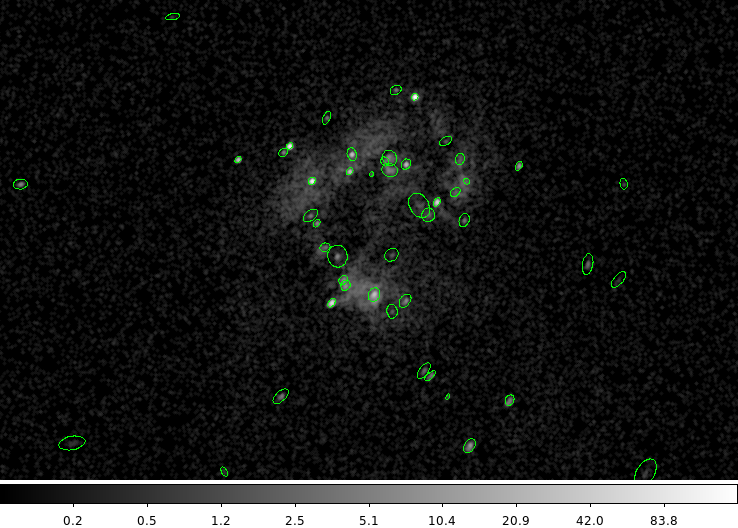

In [17]:
ds9 images/broad_thresh.img  -region sources_mod.fits \
  -region color red -region sources.fits  \
  -smooth radius 2 -smooth -scale log -saveimage png ds9_02.png &
sleep 10
xpaset -p ds9 quit

  
display < ds9_02.png

In [18]:
#dmmakereg region="region(sources_mod.fits)" out=sources_mod.fits clob+ ker=fits
dmlist sources_mod.fits cols

 
--------------------------------------------------------------------------------
Columns for Table Block SRCLIST
--------------------------------------------------------------------------------
 
ColNo  Name                 Unit        Type             Range
   1   RA                   deg          Real8          0:      360.0        Source Right Ascension
   2   DEC                  deg          Real8          -90.0:       90.0    Source Declination
   3   RA_ERR               deg          Real8          -Inf:+Inf            Source Right Ascension Error
   4   DEC_ERR              deg          Real8          -Inf:+Inf            Source Declination Error
   5   POS(X,Y)             pixel        Real8          3545.50:     4837.50 Physical coordinates
   6   X_ERR                pixel        Real8          -Inf:+Inf            Source X position error
   7   Y_ERR                pixel        Real8          -Inf:+Inf            Source Y position error
   8   NPIXSOU              pixel  

### Create src and bkg regions

In [19]:
mkdir -p sources
/bin/rm -f sources/*
pset roi infile=sources_mod.fits
pset roi outsrcfile=sources/src%d.fits
pset roi bkgfactor=0.5
roi mode=h clob+


In [20]:
pget roi num_srcs

69


In [21]:
dmlist sources_mod.fits counts

73      


In [22]:
ls -1 sources/ | head -5

src1.fits
src10.fits
src11.fits
src12.fits
src13.fits


In [23]:
dmlist sources/src1.fits blocks

 
--------------------------------------------------------------------------------
Dataset: sources/src1.fits
--------------------------------------------------------------------------------
 
     Block Name                          Type         Dimensions
--------------------------------------------------------------------------------
Block    1: PRIMARY                        Null        
Block    2: SRCREG                         Table         5 cols x 1        rows
Block    3: BKGREG                         Table         5 cols x 2        rows


[1] 28053
[1]+  Done                    ds9 -zoom 2 -smooth -scale log images/broad_thresh.img -region sources/src14.fits images/broad_thresh.img -region "sources/src14.fits[bkgreg]" -saveimage png ds9_03.png


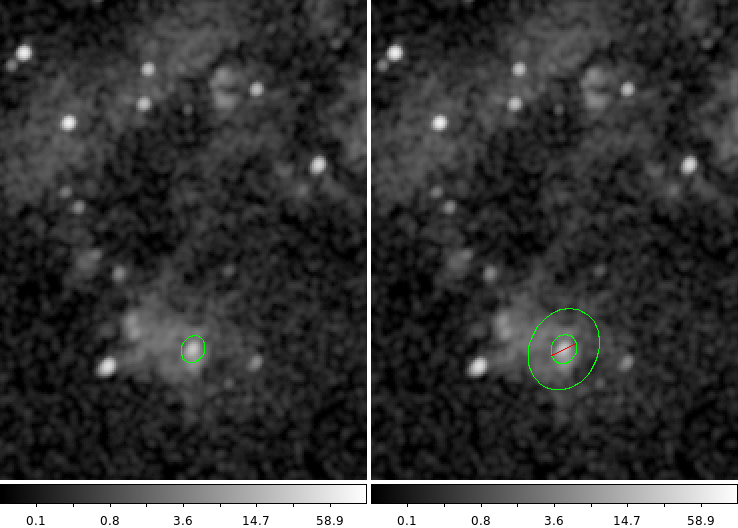

In [24]:
ds9 -zoom 2 -smooth -scale log images/broad_thresh.img -region sources/src14.fits \
     images/broad_thresh.img -region "sources/src14.fits[bkgreg]" \
     -saveimage png ds9_03.png &
sleep 10
xpaset -p ds9 quit

     
display < ds9_03.png

In [25]:
splitroi "sources/src*.fits" exclude

In [26]:
dmmakereg region="region(exclude.bg.reg)" out=exclude.bg.fits cl+ ker=fits

[1] 28099
[1]+  Done                    ds9 images/broad_thresh.img -scale log -smooth -region exclude.bg.fits -saveimage png ds9_04.png


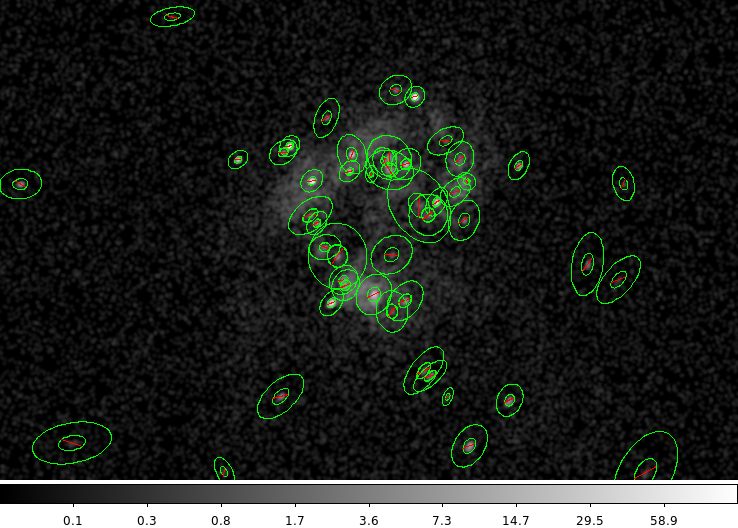

In [27]:
ds9 images/broad_thresh.img -scale log -smooth -region exclude.bg.fits \
  -saveimage png ds9_04.png &
sleep 10
xpaset -p ds9 quit


display < ds9_04.png

#### Alt using stacks

In [28]:
ls -1 sources/src*fits | sed 's/.*/region(&)/' > src.reg
head -5 src.reg

region(sources/src1.fits)
region(sources/src10.fits)
region(sources/src11.fits)
region(sources/src12.fits)
region(sources/src13.fits)


In [29]:
ls -1 sources/src*fits | sed 's/.*/region(&[bkgreg])/' > bg.reg
head -5 bg.reg

region(sources/src1.fits[bkgreg])
region(sources/src10.fits[bkgreg])
region(sources/src11.fits[bkgreg])
region(sources/src12.fits[bkgreg])
region(sources/src13.fits[bkgreg])


### Dmfilth it

In [30]:
pset dmfilth infile=images/broad_thresh.img
pset dmfilth outfile=diffuse.img
pset dmfilth method=POISSON
pset dmfilth srclist=@exclude.src.reg
pset dmfilth bkglist=@exclude.bg.reg
pset dmfilth randseed=0
dmfilth mode=h cl+ 

In [31]:
ds9 images/broad_thresh.img -invert -smooth -log  diffuse.img -smooth \
  -scale sqrt -invert -saveimage png ds9_05.png &
sleep 10
xpaset -p ds9 quit


display < ds9_05.png

[1] 28316
[1]+  Done                    ds9 images/broad_thresh.img -invert -smooth -log diffuse.img -smooth -scale sqrt -invert -saveimage png ds9_05.png


## Smooth


In [32]:
pset aconvolve infile=diffuse.img
pset aconvolve outfile=diffuse.sm.img
pset aconvolve kernelspec="lib:gaus(2,5,1,7,7)"
pset aconvolve method=fft
aconvolve mode=h clob+


[1] 28381
[1]+  Done                    ds9 images/broad_thresh.img -invert -smooth -log diffuse.sm.img -smooth -scale sqrt -invert -saveimage png ds9_06.png


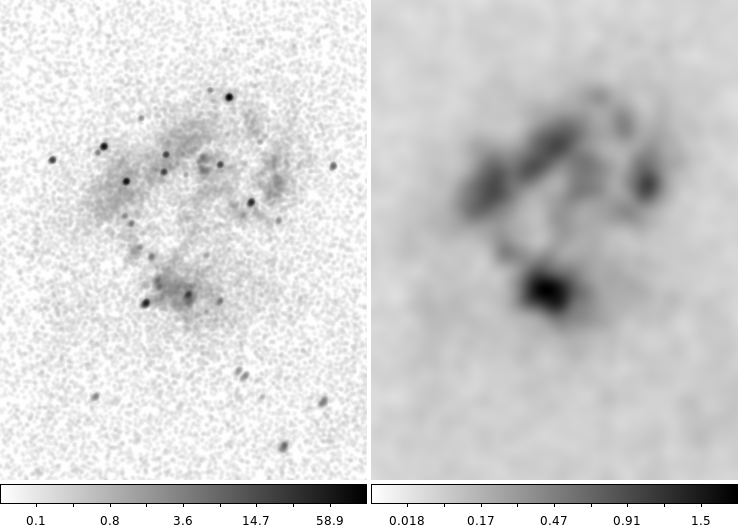

In [33]:
ds9 images/broad_thresh.img -invert -smooth -log  \
    diffuse.sm.img -smooth -scale sqrt -invert \
    -saveimage png ds9_06.png &
sleep 10
xpaset -p ds9 quit


display < ds9_06.png

## Exposure Correct

In [34]:
dmimgcalc diffuse.img images/broad_thresh.expmap diffuse_exp.img div cl+

In [35]:
aconvolve diffuse_exp.img diffuse_exp.sm.img "lib:gauss(2,5,1,7,7)" method=fft cl+

In [36]:
ds9  diffuse.sm.img -invert -scale mode 99.5 \
     diffuse_exp.sm.img -invert -scale mode 99.5 \
     -saveimage png ds9_07.png &
sleep 10
xpaset -p ds9 quit


display < ds9_07.png

[1] 28457
[1]+  Done                    ds9 diffuse.sm.img -invert -scale mode 99.5 diffuse_exp.sm.img -invert -scale mode 99.5 -saveimage png ds9_07.png


# Cleanup


In [37]:
/bin/rm -rf 315 images repro sources 